<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# CNNs to Decode Intended Saccade Direction from Macaque PFC Microelectrode Recordigns
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --single-branch --branch cboulay/macaque_pfc --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta1
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell, reset_keras
%load_ext tensorboard
plt.rcParams.update({'font.size': 16})

In [2]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'monkey_pfc'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' )} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare data from one session
TODO: Explain data.

### Load the data
Let's use a helper function from the repo to load the data.
You can see the code for `load_macaque_pfc` [here](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/utils/fileio.py)
(TODO: Point to line number).

In [57]:
from data.utils.fileio import load_macaque_pfc

SESS_ID = 'sra3_1_j_050_00'
# SESS_ID = 'sra3_1_m_074_0001'
X, Y, ax_info = load_macaque_pfc(datadir, SESS_ID, x_chunk='spikerates', zscore=True)
n_trials = len(ax_info['instance_data'])

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

Found 992 trials, 166 timestamps (-0.2 to 1.45 at 100.0 Hz), 32 channels


### Get baseline accuracy

Next we will use "shallow" machine learning techniques to train a model to predict intended saccade direction.

#### LDA
A good first approach would be to use multi-class LDA. Given the number of features (timestamps * channels), LDA is likely to over-fit. We can use regularization. However, sk-learn's LDA regularization relies on the `'eigen'` solver which can run out of memory when operating on very large feature matrices. You can try the cell below, but it may not work depending on how many channels and timestamps we have. sk-learn probably has other mechanisms to regularize LDA, but we'll instead use a different ML algorithm in a couple cells below.

In [4]:
# Depending on data shape you may run out of memory here.
# Either way, you can achieve the same result using a different method in the next code cell.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold


lda = LDA(shrinkage='auto', solver='eigen')
splitter = StratifiedKFold(n_splits=10, shuffle=True)

y_preds = []
y_true = []
fold_ix = 0
for trn, tst in splitter.split(X, Y):
    fold_ix += 1
    print("Fold {}".format(fold_ix))
    lda.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(lda.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 83.35517693315859


#### Logistic Regression
Instead of LDA, we'll use Logistic Regression. sk-learn's regularization scheme for logistic regression is more robust than for LDA. This is a CPU-intensive task and is a bit slow on Colab.

Note: Though 'Logistic Regression' has 'regression' in the name, it's actually a classification algorithm.

We start by using all available time points to try to get the best accuracy.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
args = {
    'solver': 'lbfgs',
    'C': 10.0,  # inverse regularization strength
    'penalty': 'l2',
    'multi_class': 'ovr',
    'max_iter': 500
}
model = LogisticRegression(**args)
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 60.34318398474738


The accuracy using shallow methods is around 60% for monkey M and 81-83% for monkey J. Is this good?

There are 8 different classes in the data. Chance accuracy _should_ be 12.5%. However, condition-pairs were presented in blocks, so a classifier that could simply identify "block" (e.g. by heavily weighting transient neurons) would achieve ~50% accuracy. The best way to know is to run the classifier again using only data available before any stimulus was presented, and again using only data after the stimulus was presented but before the cue indicated the correct stimulus was presented.

Next we run the classification using only the data from before the targets were presented.

In [23]:
args['max_iter'] = 1000
model = LogisticRegression(**args)
b_times = ax_info['timestamps'] < 0
_X = X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-trial data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy using pre-trial data only: 28.979980934223068%


Then we run it again using only the data before the cues appeared, including the 0.25 s after the targets appeared.
At this point, the monkey knows the two potential target locations. He/she will know which is the cue and which is the target only after cue onset.

In [24]:
b_times = ax_info['timestamps'] < 0.250
_X = X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-cue data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy using pre-cue data only: 42.040038131553864%


Without any stimulus information at all, decoder accuracy was 29-34%. Including neural data after the target-distractor pair appeared, but before the cue appeared (i.e. before the monkey had enough information to know the correct target), decoder accuracy was 42-47%. Our decoder using all of the data up to the imperative cue had an accuracy of 60% in one dataset and 81% in another, which is much higher than these 'baseline' values. These results suggest that the model learned something about the relationship between neural activity and intended saccade direction.

### Prepare data for deep learning

In [25]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        x_dat = tf.cast(x_dat, tf.float32)
        x_dat = tf.expand_dims(x_dat, -1)  # Prepare as an image, with only 1 colour channel.
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)  # , drop_remainder=True?
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

## Create our model
Our model objective is to transform timeseries data into probabilities of each class.



In [58]:
# EEGNet-like model. https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
# See explanation of depthwise and separable convs here:
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers

"""
Best Parameters: {'D': 7.0, 'dropout_rate': 0.1593798685065428,
'kern_length_1': 8.0, 'kern_length_2': 10.0,
'l2_reg': 1.2201515371341046e-06,
'n_pointwise_filters': 15.0, 'n_temporal_filters': 42.0,
'norm_rate': 0.4260960308458442}
"""

def make_model(T, C,
               aug_offset=5,
               n_temporal_filters=22,  # 22
               kern_length_1=20, downsamp_1=2,  # 32, 2
               D=4,  # 3
               n_pointwise_filters=15, kern_length_2=16, downsamp_2=2,  # 14, 16, 2
               norm_rate=0.40, dropout_rate=0.5, l2_reg=0.00001  # 0.35, 0.4
              ):
    """
    Create EEGNet-like model.
    :param T: Number of time-steps in input
    :param C: Number of channels in input
    :param aug_offset: maximum number of samples to shift training data for augmentation.
    :param n_temporal_filters: We need enough temporal filters to capture all within-channel patterns * scales.
     e.g. oscillations at different freqs, evoked potentials, transition between bistable firing rates.
    :param kern_length_1: Temporal filter kernel length should be long enough to capture slow features.
     e.g. 2 Hz oscillations or long ERPs req ~500 msec
    :param downsamp_1: First downsample factor. If we started with 2-seconds at 40 Hz, a 4x downsample yields 2-seconds at 10-Hz.
    :param D: Spatial_filters per temporal filter.
    :param n_pointwise_filters: Output of transformation across (n_temporal_filters * D filters) filters
    :param kern_length_2: Length of kernel for second time-domain convolution.
    :param downsamp_2:
    :param norm_rate: kernel_constraint max_norm parameter in final Dense layer.
    :param dropout_rate:
    :param l2_reg:
    :return: model
    """

    model = tf.keras.models.Sequential([
        # 2-D filter has len=1 in the 'space'/'channels' dimension. Effectively the same filter is used in all channels.
        layers.Conv2D(n_temporal_filters, (kern_length_1, 1), padding='valid',
                      input_shape=(T - aug_offset, C, 1),
                      kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                      use_bias=False),
        layers.BatchNormalization(axis=1),
        # First layer yields output of a bank of time-domain filters.
        # Next we apply spatial filters (1, C). There are D spatial filters for each temporal filter.
        layers.DepthwiseConv2D((1, C), use_bias=False,
                               depth_multiplier=D,
                               kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                               depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                               depthwise_constraint=max_norm(1.)),
        layers.BatchNormalization(axis=1),
        layers.Activation('elu'),
        layers.AveragePooling2D((downsamp_1, 1)),
        layers.Dropout(dropout_rate),
        
        layers.SeparableConv2D(n_pointwise_filters, (kern_length_2, 1), padding='valid',
                               use_bias=False),
        layers.BatchNormalization(axis=1),
        layers.Activation('elu'),
        layers.AveragePooling2D((downsamp_2, 1)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(8, kernel_constraint=max_norm(norm_rate)),
        layers.Activation('softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

model = make_model(X.shape[1], X.shape[2])
model.summary()
reset_keras(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 142, 32, 22)       440       
_________________________________________________________________
batch_normalization (BatchNo (None, 142, 32, 22)       568       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 142, 1, 88)        2816      
_________________________________________________________________
batch_normalization_1 (Batch (None, 142, 1, 88)        568       
_________________________________________________________________
activation (Activation)      (None, 142, 1, 88)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 71, 1, 88)         0         
_________________________________________________________________
dropout (Dropout)            (None, 71, 1, 88)         0

### Train the model
We use 100 epochs which is probably overkill for this particular dataset.
However, we've put in some guards against over-fitting so we might still expect this to perform well on the validation set.

In [59]:
N_SPLITS = 10
BATCH_SIZE = 10
MAX_OFFSET = 5  # 30
N_EPOCHS = 100

In [60]:
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
split_ix = 0
best_val_accs = []
hists = []
for trn, tst in splitter.split(X, Y):
    print("Starting split {}".format(split_ix))
    
    # Get the training/testing data for this split.
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    # Create new model
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET)

    # Callback to save only the best (highest validation accuracy) model weights during training.
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(datadir / 'converted' / (SESS_ID + '_model{}_best.h5'.format(split_ix))),
            save_best_only=True,
            monitor='val_accuracy',
            verbose=0)
    ]
    
    # Train model
    history = model.fit(x=ds_train,  
                        epochs=N_EPOCHS, 
                        validation_data=ds_valid,
                        callbacks=callbacks,
                        verbose=0)
    hists.append(history.history)
    
    bva = 100*max(history.history['val_accuracy'])
    print("Split {}: Best validation accuracy {:.2f}%".format(split_ix, bva))
    best_val_accs.append(bva)
    split_ix += 1
    reset_keras(model)

print("%.2f%% (+/- %.2f%%)" % (np.mean(best_val_accs), np.std(best_val_accs)))

best_path = datadir / 'converted' / (SESS_ID + '_model{}_best.h5'.format(np.argmax(best_val_accs)))
best_path.replace(datadir / 'converted' / (SESS_ID + '_model_best_all.h5'))

# Download 'best' model anytime with
# files.download(datadir / 'converted' / (SESS_ID + '_model_best_all.h5'))

Starting split 0
Split 0: Best validation accuracy 89.32%
208655
Starting split 1
Split 1: Best validation accuracy 80.58%
185535
Starting split 2
Split 2: Best validation accuracy 85.29%
185535
Starting split 3
Split 3: Best validation accuracy 84.31%
185535
Starting split 4
Split 4: Best validation accuracy 83.84%
185535
Starting split 5
Split 5: Best validation accuracy 83.84%
185535
Starting split 6
Split 6: Best validation accuracy 87.63%
185535
Starting split 7
Split 7: Best validation accuracy 88.54%
185535
Starting split 8
Split 8: Best validation accuracy 81.25%
185535
Starting split 9
Split 9: Best validation accuracy 89.47%
185535
85.41% (+/- 3.05%)


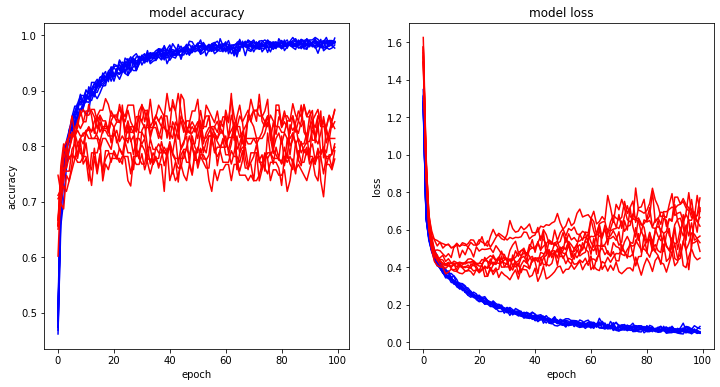

In [61]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(np.vstack([_['accuracy'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_accuracy'] for _ in hists]).T, 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(np.vstack([_['loss'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_loss'] for _ in hists]).T, 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Our goal is for the deep model to do at least as well as logistic regression, which gave cross-validated classification accuracies of ~60% and ~81% in two datasets. Using the EEGNet CNN, we achieve 74% and 85%. The improvement on the first dataset improves classification above the unofficial threshold for acceptable BCI performance.

We expect the deep model will be useful in other ways too.

## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)



In [62]:
# Load the 'best' model from disk.
from tensorflow.keras.models import load_model
model = load_model(datadir / 'converted' / (SESS_ID + '_model_best_all.h5'))
# model.summary()

### t-Distributed Stochastic Neighbour Embedding (t-SNE)

https://distill.pub/2016/misread-tsne/

From [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

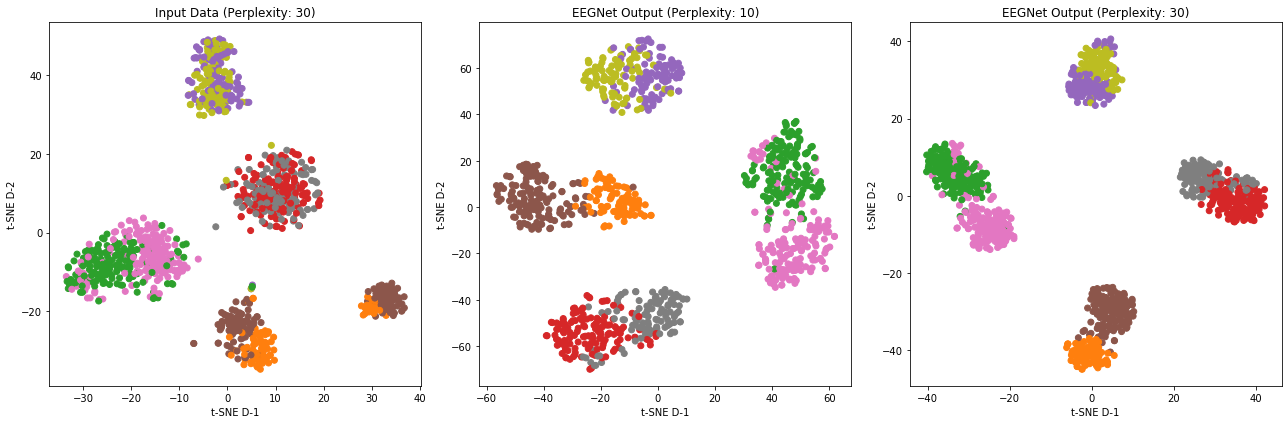

In [63]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))
class_colors = np.array([next(colour_codes) for _ in range(10)])
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])

TEST_PERPLEXITY = [10, 30]

fig = plt.figure(figsize=(18, 6), facecolor='white')
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title + ' (Perplexity: {})'.format(perplexity))
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(1, 3, 1)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY[-1], title='Input Data')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -3
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = truncated_model(X[:, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None])

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(flattened_output)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, Y.ravel()+1, perplexity, title='EEGNet Output')

plt.tight_layout()
fig.savefig(str(datadir / 'converted' / (SESS_ID + '_CNN_tSNE.png')))

t-SNE on the untransformed data shows two different clusters for blue/magenta trial pairs.
These probably came at two different blocks of time, between which there was a change in the neural activations.
After transforming the data, these classes are grouped together.

### First convolutional layer
The first convolutional layer is simply performing time-domain convolution. Interpreting this layer is similar to visualizing filter characteristics.

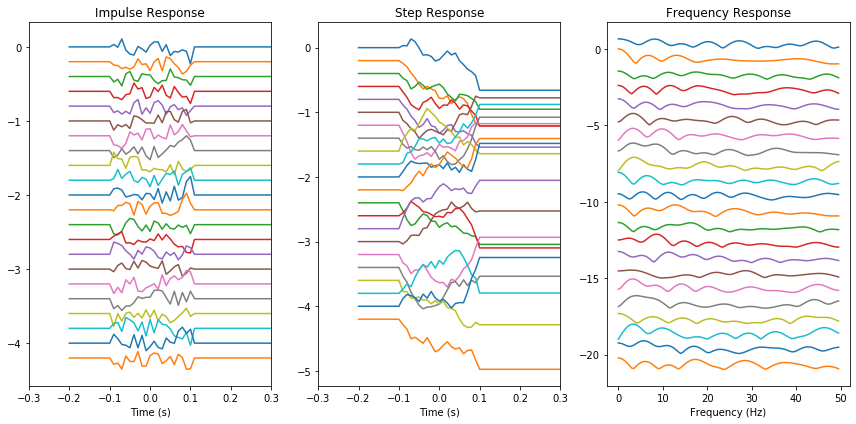

In [64]:
import scipy.signal

filters = np.squeeze(model.layers[0].get_weights()[0])
t = ax_info['timestamps']

fig = plt.figure(figsize=(12, 6), facecolor='white')

# Impulse response
impulse = np.zeros_like(t)
impulse[np.argmin(np.abs(t))] = 1.0
plt.subplot(1, 3, 1)
for filt_ix, filt_coeff in enumerate(filters.T):
    imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
    plt.plot(t, imp_conv - 0.2*filt_ix)
plt.xlim((-0.3, 0.3))
plt.xlabel('Time (s)')
plt.title('Impulse Response')

# Step response
step = np.zeros_like(t)
step[np.argmin(np.abs(t)):] = 1.0
plt.subplot(1, 3, 2)
for filt_ix, filt_coeff in enumerate(filters.T):
    step_response = scipy.signal.convolve(step, filt_coeff, 'same')
    plt.plot(t, step_response - 0.2*filt_ix)
plt.xlim((-0.3, 0.3))
plt.xlabel('Time (s)')
plt.title('Step Response')

plt.subplot(1, 3, 3)
for filt_ix, filt_coeff in enumerate(filters.T):
    f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
    plt.plot(f, np.abs(resp) - filt_ix)
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Response')

plt.tight_layout()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

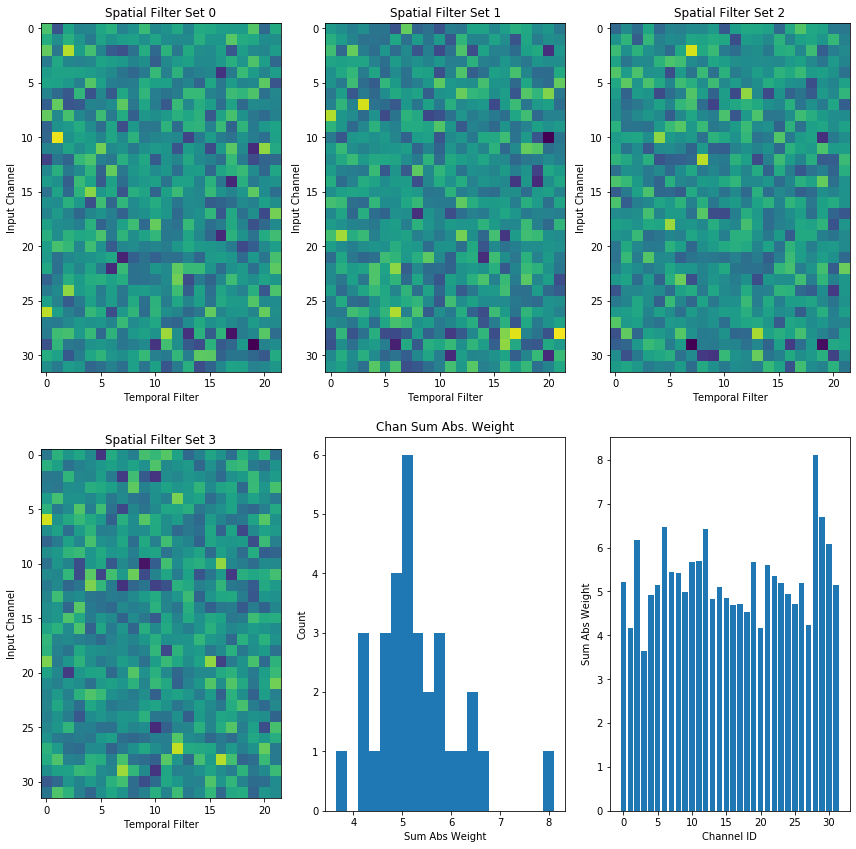

In [65]:
spatial_filter = model.layers[2].get_weights()[0][0]
D = spatial_filter.shape[-1]
sp_cols = int(np.ceil(np.sqrt(D + 2)))
sp_rows = int(np.ceil((D + 2) / sp_cols))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12), facecolor='white')
for depth_ix in range(D):
    plt.subplot(sp_rows, sp_cols, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()

sum_abs_weight = np.sum(np.sum(np.abs(spatial_filter), axis=1), axis=-1)
plt.subplot(sp_rows, sp_cols, D + 1)
plt.hist(sum_abs_weight, 20)
plt.xlabel('Sum Abs Weight')
plt.ylabel('Count')
plt.title('Chan Sum Abs. Weight')

plt.subplot(sp_rows, sp_cols, D + 2)
plt.bar(np.arange(spatial_filter.shape[0]), sum_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Sum Abs Weight')

plt.tight_layout()
plt.show()

ch_ids = np.argsort(sum_abs_weight)[::-1]  # channel_ids sorted by weight, descending

There seems to be a small group of channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

# Maximum activations

Another useful way to understand what a convolutional layers is doing, especially for deeper layers that are combining abstract features, is to visualize an input that would maximize activation of a filter(s) within the layer. How do we do that?

Remembering back to the manual step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function for a given set of _inputs_. Now we know the weights but we want to find the inputs that _maximize_ the activation (a.k.a. output) of a filter. We're going to use the same loss-minimization training framework, but instead of calculating a 'loss', we will calculate the mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to maximize output (i.e., step the input up the gradients).

In [66]:
from tensorflow.keras import backend as K

def plot_layer(layer_ix, max_filts=None, n_steps=100):
    in_shape = [1] + model.input.shape.as_list()[1:]
    
    layer_output = model.layers[layer_ix].output
    n_filts = layer_output.shape[-1]
    filt_ids = np.arange(n_filts)
    if (max_filts is not None) and (len(filt_ids) > max_filts):
        filt_ids = filt_ids[np.argsort(np.random.rand(n_filts))][:max_filts]
    
    fig = plt.figure(figsize=(12, 12), facecolor='white')
    sp_cols = int(np.ceil(np.sqrt(len(filt_ids))))
    sp_rows = int(np.ceil(len(filt_ids) / sp_cols))
    
    filt_slice = [np.s_[:] for _ in range(K.ndim(layer_output))]
    
    for ix, filt_ix in enumerate(filt_ids):
        input_data = tf.convert_to_tensor(np.random.randn(*in_shape).astype(np.float32))
        if layer_ix > (len(model.layers) - 3):
            # model.layers[layer_ix].activation == tf.keras.activations.softmax:
            max_model = tf.keras.Model(model.input, layer_output)
            non_targ_id = tf.constant(np.setdiff1d(np.arange(layer_output.shape[-1], dtype=int), filt_ix))
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    targ_act = filter_act[0, filt_ix]
                    nontarg_act = K.mean(tf.gather(filter_act, non_targ_id, axis=-1))
                    loss_value = targ_act - nontarg_act
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        else:
            filt_slice[-1] = filt_ix
            max_model = tf.keras.Model(model.input, layer_output[tuple(filt_slice)])
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    loss_value = K.mean(filter_act)
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        input_data = np.squeeze(input_data)

        plt.subplot(sp_rows, sp_cols, ix + 1)
        plt.plot(t[MAX_OFFSET:], input_data[:, ch_ids[:4]])
        plt.xlabel('Time After Target Onset (s)')
        plt.ylabel('Filter {}'.format(filt_ix))
        plt.title('Output {:.2f}'.format(loss_value.numpy()))
        for xx in [0, 0.25, 1.25]:
            plt.axvline(xx, color='k', linestyle='--')
        
    plt.tight_layout()

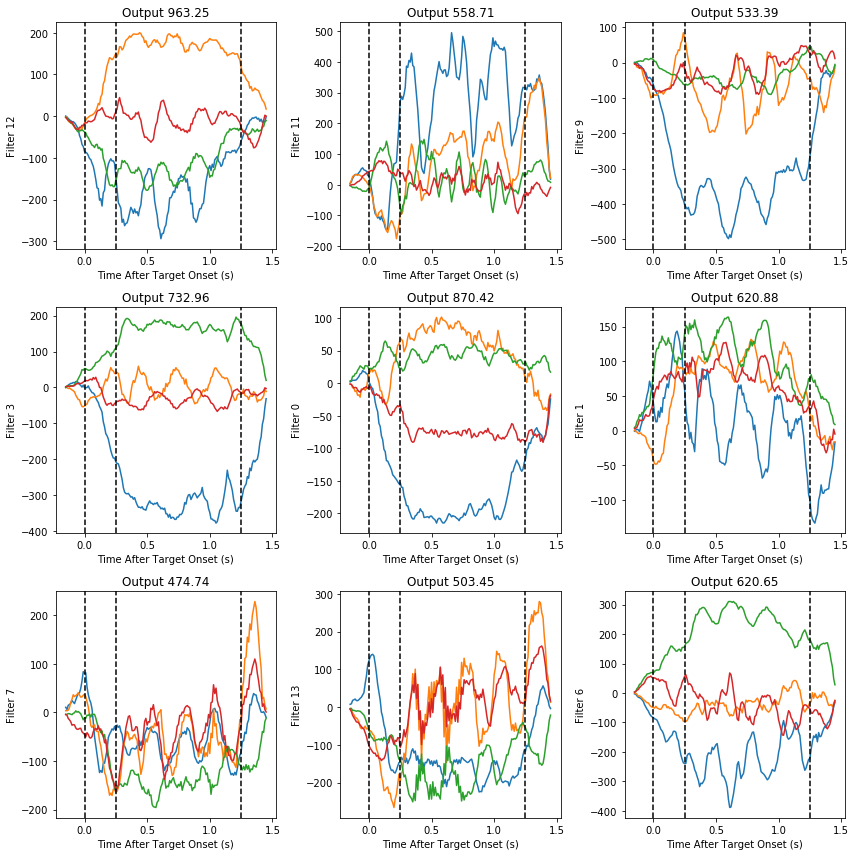

In [67]:
# 0 is conv2d with 22 filts, 2 is depthwiseConv2D w/ 66, 7 is SeparableConv2D w/ 16
plot_layer(7, max_filts=9)

### Class Activation Maximization
If we extend our reasoning from filter activations down to the next-to-last layer (13), and we choose a 'loss' that maximizes one class, we can plot maximization signals for each of the 8 output classes. If we were to do the same on the final Softmax layer (14), the results have a similar shape but are quite noisy because perfect classification is achieved quickly and thus there is no more gradient.

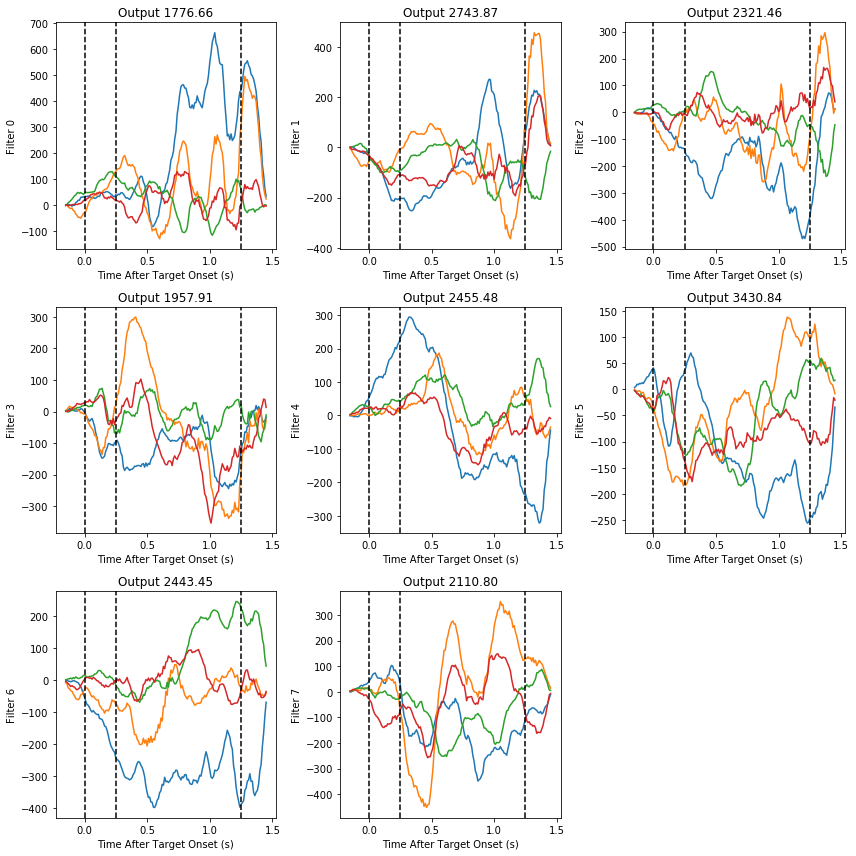

In [68]:
plot_layer(13, n_steps=100)

### Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [ ]:
from tensorflow.keras import backend as K
N_TRIALS = 9
test_class = 0
classes, y = np.unique(Y, return_inverse=True)
trial_ids = np.where(y == classes.tolist().index(test_class))[0]

losses_grads = []
for tr_id in trial_ids:
    input_data = tf.convert_to_tensor(X[tr_id, :, :].astype(np.float32)[None, :, :])
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        class_proba = model(input_data)
        loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
    grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
    # Normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
    losses_grads.append((loss_value, grads))

In [ ]:
loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.concatenate([_[1].numpy() for _ in losses_grads], axis=0)
re_ix = np.argsort(loss_vals)
_x = X[trial_ids][re_ix][:3]
_masks = grad_vals[re_ix][:3]

for tr_ix in range(3):
    plt.subplot(3, 1, tr_ix + 1)
    plt.plot(_x[tr_ix, :, ch_ids[0]])
    ax2=plt.twinx()
    ax2.plot(_masks[tr_ix, :, ch_ids[0]], 'k')

### Class Activation Maps
Class activation maps highlight the parts of the input that contribute most to each classification score.
This is similar but different to saliency mapping, and has largely replaced saliency mapping.
While we don't have any code to do class activation mapping (yet), there are a couple examples in the slides for Part 3.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.7

def evaluate_model(params, verbose=0):
    print(params)
    n_temporal_filters = params.get('n_temporal_filters', 22)
    kern_length_1 = params.get('kern_length_1', 32)
    downsamp_1 = params.get('downsamp_1', 2)
    D = params.get('D', 3)
    n_pointwise_filters = params.get('n_pointwise_filters', 14)
    kern_length_2 = params.get('kern_length_2', 16)  # int(kern_length_1 // downsamp_1))
    downsamp_2 = params.get('downsamp_2', 2)
    norm_rate = params.get('norm_rate', 0.35)
    dropout_rate = params.get('dropout_rate', 0.4)
    l2_reg = params.get('l2_reg', 0.00001)
    epochs = params.get('epochs', 100)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN)
    trn, tst = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET,
                       n_temporal_filters=n_temporal_filters,
                       kern_length_1=kern_length_1, downsamp_1=downsamp_1,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, kern_length_2=kern_length_2, downsamp_2=downsamp_2,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    min_val_loss = min(history.history['val_loss'])
    print("Min validation loss with these parameters: {}".format(min_val_loss))
    
    reset_keras(model)
    reset_keras(model)  # Just to be sure...
    
    return min_val_loss

In [32]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest


space = {
    'n_temporal_filters': scope.int(hp.quniform('n_temporal_filters', 2, 65, 1)),
    'kern_length_1': scope.int(hp.quniform('kern_length_1', 4, 64, 1)),
#     'downsamp_1': scope.int(hp.quniform('downsamp_1', 2, 9, 1)),
    'D': scope.int(hp.quniform('D', 1, 8, 1)),
    'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
    'kern_length_2': scope.int(hp.quniform('kern_length_2', 4, 32, 1)),
#     'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 8, 1)),
    'norm_rate': hp.uniform('norm_rate', 0., 0.5),
    'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
    'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(0.1)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
}

trials = Trials()  # object that holds iteration results
#Do optimization
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=300, trials=trials)
print("Best Loss: {}".format(trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

{'D': 6, 'dropout_rate': 0.11916087069210246, 'kern_length_1': 31, 'kern_length_2': 27, 'l2_reg': 0.0013490711326572663, 'n_pointwise_filters': 32, 'n_temporal_filters': 58, 'norm_rate': 0.25151800801805807}
Min validation loss with these parameters: 0.9604126382619143                                                          
23                                                                                                                     
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.4414625362162599, 'kern_length_1': 58, 'kern_length_2': 10, 'l2_reg': 0.002597423284150444, 'n_pointwise_filters': 15, 'n_temporal_filters': 43, 'norm_rate': 0.011547906696793009}
Min validation loss with these parameters: 1.3316870741546154                                                          
74765                                                                                                    

Min validation loss with these parameters: 0.9027396626770496                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.30059637890185065, 'kern_length_1': 13, 'kern_length_2': 30, 'l2_reg': 8.847175508985995e-06, 'n_pointwise_filters': 65, 'n_temporal_filters': 25, 'norm_rate': 0.48329162339424714}
Min validation loss with these parameters: 0.9395469631999731                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 4, 'dropout_rate': 0.48693270649288595, 'kern_length_1': 31, 'kern

210                                                                                                                    
{'D': 3, 'dropout_rate': 0.15978409912137875, 'kern_length_1': 18, 'kern_length_2': 20, 'l2_reg': 0.0010984535068182311, 'n_pointwise_filters': 29, 'n_temporal_filters': 21, 'norm_rate': 0.4517777336105814}
Min validation loss with these parameters: 0.8639956098049879                                                          
209077                                                                                                                 
210                                                                                                                    
{'D': 1, 'dropout_rate': 0.2400942089103356, 'kern_length_1': 53, 'kern_length_2': 17, 'l2_reg': 4.473585861561513e-05, 'n_pointwise_filters': 14, 'n_temporal_filters': 10, 'norm_rate': 0.3539298376134592}
Min validation loss with these parameters: 0.7681496925652027                                              

{'D': 5, 'dropout_rate': 0.08474064949898027, 'kern_length_1': 59, 'kern_length_2': 22, 'l2_reg': 0.00019511630542021587, 'n_pointwise_filters': 36, 'n_temporal_filters': 46, 'norm_rate': 0.19935410767153924}
Min validation loss with these parameters: 0.8742616297677159                                                          
209078                                                                                                                 
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.34073381201510544, 'kern_length_1': 13, 'kern_length_2': 11, 'l2_reg': 2.031867063842928e-06, 'n_pointwise_filters': 31, 'n_temporal_filters': 18, 'norm_rate': 0.19232490627824073}
Min validation loss with these parameters: 0.7952153254300356                                                          
209078                                                                                                 

Min validation loss with these parameters: 0.7875962853431702                                                          
209078                                                                                                                 
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.2892223736775707, 'kern_length_1': 32, 'kern_length_2': 7, 'l2_reg': 0.0006906388436876954, 'n_pointwise_filters': 24, 'n_temporal_filters': 15, 'norm_rate': 0.4623521026164049}
Min validation loss with these parameters: 0.8217200245708227                                                          
209078                                                                                                                 
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.0705917214525931, 'kern_length_1': 26, 'kern_len

210                                                                                                                    
{'D': 4, 'dropout_rate': 0.09638652589597536, 'kern_length_1': 6, 'kern_length_2': 24, 'l2_reg': 7.138595426976629e-06, 'n_pointwise_filters': 26, 'n_temporal_filters': 27, 'norm_rate': 0.4162365883492366}
Min validation loss with these parameters: 0.9187602391466498                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.06244848343814925, 'kern_length_1': 20, 'kern_length_2': 22, 'l2_reg': 1.711228939394638e-06, 'n_pointwise_filters': 37, 'n_temporal_filters': 40, 'norm_rate': 0.24206937971415682}
Min validation loss with these parameters: 0.9279627427458763                                             

{'D': 1, 'dropout_rate': 0.2723511445135655, 'kern_length_1': 32, 'kern_length_2': 16, 'l2_reg': 1.6767734157085006e-05, 'n_pointwise_filters': 2, 'n_temporal_filters': 4, 'norm_rate': 0.36414418174090557}
Min validation loss with these parameters: 0.8932229373604059                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 4, 'dropout_rate': 0.17347662140433334, 'kern_length_1': 56, 'kern_length_2': 7, 'l2_reg': 0.0003383373047916441, 'n_pointwise_filters': 30, 'n_temporal_filters': 8, 'norm_rate': 0.3161312784296231}
Min validation loss with these parameters: 0.8720685038715601                                                          
209068                                                                                                       

Min validation loss with these parameters: 0.8454264290630817                                                          
209068                                                                                                                 
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.09246539730959279, 'kern_length_1': 22, 'kern_length_2': 26, 'l2_reg': 6.779213410442157e-06, 'n_pointwise_filters': 65, 'n_temporal_filters': 30, 'norm_rate': 0.2630000294483865}
Min validation loss with these parameters: 0.9495625123381615                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 4, 'dropout_rate': 0.1669137152069836, 'kern_length_1': 8, 'kern_le

210                                                                                                                    
{'D': 2, 'dropout_rate': 0.19395545293968736, 'kern_length_1': 22, 'kern_length_2': 16, 'l2_reg': 1.9566641358727644e-06, 'n_pointwise_filters': 50, 'n_temporal_filters': 14, 'norm_rate': 0.07371471566741125}
Min validation loss with these parameters: 0.8699969714507461                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 6, 'dropout_rate': 0.04318932828884264, 'kern_length_1': 8, 'kern_length_2': 23, 'l2_reg': 0.021269875590048032, 'n_pointwise_filters': 35, 'n_temporal_filters': 44, 'norm_rate': 0.4571029650743619}
Min validation loss with these parameters: 1.0036546345800161                                             

{'D': 3, 'dropout_rate': 0.08996594037256561, 'kern_length_1': 32, 'kern_length_2': 31, 'l2_reg': 0.0010592244665051942, 'n_pointwise_filters': 48, 'n_temporal_filters': 12, 'norm_rate': 0.17259266683157015}
Min validation loss with these parameters: 0.7933427281677723                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 2, 'dropout_rate': 0.12335600704419447, 'kern_length_1': 23, 'kern_length_2': 12, 'l2_reg': 4.468345200752084e-06, 'n_pointwise_filters': 41, 'n_temporal_filters': 52, 'norm_rate': 0.44221418425471914}
Min validation loss with these parameters: 0.8124268176034093                                                          
209069                                                                                                  

Min validation loss with these parameters: 0.8956245984882116                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 2, 'dropout_rate': 0.10507657025220854, 'kern_length_1': 18, 'kern_length_2': 10, 'l2_reg': 0.00014680687092416436, 'n_pointwise_filters': 23, 'n_temporal_filters': 55, 'norm_rate': 0.4494554447588025}
Min validation loss with these parameters: 0.8244122518226504                                                          
209078                                                                                                                 
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.12821022090229917, 'kern_length_1': 12, 'kern

210                                                                                                                    
{'D': 8, 'dropout_rate': 0.0440598262485455, 'kern_length_1': 6, 'kern_length_2': 4, 'l2_reg': 4.096082485666045e-06, 'n_pointwise_filters': 20, 'n_temporal_filters': 38, 'norm_rate': 0.4399380566066029}
Min validation loss with these parameters: 0.7983304057270288                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.028277010533262148, 'kern_length_1': 5, 'kern_length_2': 5, 'l2_reg': 1.6475011234391442e-05, 'n_pointwise_filters': 5, 'n_temporal_filters': 40, 'norm_rate': 0.425849734434898}
Min validation loss with these parameters: 0.8474055025726557                                                  

{'D': 6, 'dropout_rate': 0.06594937334851342, 'kern_length_1': 15, 'kern_length_2': 4, 'l2_reg': 0.0001872274594161549, 'n_pointwise_filters': 15, 'n_temporal_filters': 36, 'norm_rate': 0.43271889421884185}
Min validation loss with these parameters: 0.7651779726147652                                                          
209068                                                                                                                 
210                                                                                                                    
{'D': 8, 'dropout_rate': 0.16749640038817923, 'kern_length_1': 14, 'kern_length_2': 5, 'l2_reg': 7.228198071269403e-06, 'n_pointwise_filters': 22, 'n_temporal_filters': 45, 'norm_rate': 0.37465768830219076}
Min validation loss with these parameters: 0.839949824847281                                                           
209069                                                                                                    

Min validation loss with these parameters: 0.7747846273705363                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 6, 'dropout_rate': 0.049152459845191114, 'kern_length_1': 20, 'kern_length_2': 6, 'l2_reg': 6.344630391031057e-06, 'n_pointwise_filters': 16, 'n_temporal_filters': 43, 'norm_rate': 0.3286827036570408}
Min validation loss with these parameters: 0.7895932318642735                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.0618799607977558, 'kern_length_1': 12, 'kern_l

210                                                                                                                    
{'D': 6, 'dropout_rate': 0.1735240310052942, 'kern_length_1': 24, 'kern_length_2': 14, 'l2_reg': 2.6918877102785582e-05, 'n_pointwise_filters': 21, 'n_temporal_filters': 49, 'norm_rate': 0.34619933684886245}
Min validation loss with these parameters: 0.7666655406355858                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 8, 'dropout_rate': 0.08953850454409655, 'kern_length_1': 22, 'kern_length_2': 12, 'l2_reg': 2.285850929101103e-06, 'n_pointwise_filters': 19, 'n_temporal_filters': 25, 'norm_rate': 0.4669655080767534}
Min validation loss with these parameters: 0.8632339294999838                                            

{'D': 6, 'dropout_rate': 0.18471969445888536, 'kern_length_1': 31, 'kern_length_2': 15, 'l2_reg': 1.4717257785911082e-06, 'n_pointwise_filters': 12, 'n_temporal_filters': 21, 'norm_rate': 0.4024049986981606}
Min validation loss with these parameters: 0.8396003814414144                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.08625594260294453, 'kern_length_1': 8, 'kern_length_2': 20, 'l2_reg': 0.00015157256001740172, 'n_pointwise_filters': 19, 'n_temporal_filters': 58, 'norm_rate': 0.43750191106312003}
Min validation loss with these parameters: 0.8479266073554754                                                          
209069                                                                                                  

Min validation loss with these parameters: 0.8527713837102056                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 6, 'dropout_rate': 0.010224982746209019, 'kern_length_1': 29, 'kern_length_2': 13, 'l2_reg': 1.4823839595742663e-05, 'n_pointwise_filters': 5, 'n_temporal_filters': 29, 'norm_rate': 0.46109498204229554}
Min validation loss with these parameters: 0.7995134647935629                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.215311706231711, 'kern_length_1': 23, 'kern_

210                                                                                                                    
{'D': 1, 'dropout_rate': 0.3190800940164208, 'kern_length_1': 7, 'kern_length_2': 17, 'l2_reg': 1.0154573616574122e-06, 'n_pointwise_filters': 8, 'n_temporal_filters': 4, 'norm_rate': 0.48981882304003144}
Min validation loss with these parameters: 0.805694717913866                                                           
209068                                                                                                                 
210                                                                                                                    
{'D': 6, 'dropout_rate': 0.3076369559911881, 'kern_length_1': 4, 'kern_length_2': 7, 'l2_reg': 3.485295919850864e-06, 'n_pointwise_filters': 14, 'n_temporal_filters': 7, 'norm_rate': 0.45181270549667774}
Min validation loss with these parameters: 0.8050485299900174                                                  

{'D': 8, 'dropout_rate': 0.2875546940496644, 'kern_length_1': 9, 'kern_length_2': 10, 'l2_reg': 2.1767404143578635e-06, 'n_pointwise_filters': 13, 'n_temporal_filters': 7, 'norm_rate': 0.4000385290204401}
Min validation loss with these parameters: 0.7692310176789761                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.2615362610663301, 'kern_length_1': 6, 'kern_length_2': 11, 'l2_reg': 1.3682937735245676e-06, 'n_pointwise_filters': 10, 'n_temporal_filters': 20, 'norm_rate': 0.4271514479915398}
Min validation loss with these parameters: 0.8177122296765447                                                          
209069                                                                                                       

Min validation loss with these parameters: 0.8157439976930618                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 8, 'dropout_rate': 0.30901663116084377, 'kern_length_1': 5, 'kern_length_2': 12, 'l2_reg': 1.4849045674753213e-05, 'n_pointwise_filters': 6, 'n_temporal_filters': 12, 'norm_rate': 0.3549361625669375}
Min validation loss with these parameters: 0.8486186331138015                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 8, 'dropout_rate': 0.2826051769013754, 'kern_length_1': 10, 'kern_le

210                                                                                                                    
{'D': 8, 'dropout_rate': 0.42499487961213045, 'kern_length_1': 8, 'kern_length_2': 10, 'l2_reg': 1.2363373404942424e-05, 'n_pointwise_filters': 26, 'n_temporal_filters': 13, 'norm_rate': 0.3800002772967581}
Min validation loss with these parameters: 0.7868669712916017                                                          
209069                                                                                                                 
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.3423439305799927, 'kern_length_1': 11, 'kern_length_2': 11, 'l2_reg': 0.014665109047548657, 'n_pointwise_filters': 21, 'n_temporal_filters': 9, 'norm_rate': 0.40635175950045954}
Min validation loss with these parameters: 0.9045403450727463                                               

In [40]:
np.argsort([_['result']['loss'] for _ in trials.trials])
trials.trials[267]

{'state': 2,
 'tid': 267,
 'spec': None,
 'result': {'loss': 0.6993314190767705, 'status': 'ok'},
 'misc': {'tid': 267,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'D': [267],
   'dropout_rate': [267],
   'kern_length_1': [267],
   'kern_length_2': [267],
   'l2_reg': [267],
   'n_pointwise_filters': [267],
   'n_temporal_filters': [267],
   'norm_rate': [267]},
  'vals': {'D': [7.0],
   'dropout_rate': [0.28801679257518864],
   'kern_length_1': [6.0],
   'kern_length_2': [11.0],
   'l2_reg': [7.227037943833785e-06],
   'n_pointwise_filters': [17.0],
   'n_temporal_filters': [10.0],
   'norm_rate': [0.4259565709839446]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2019, 8, 10, 14, 20, 31, 313000),
 'refresh_time': datetime.datetime(2019, 8, 10, 14, 22, 3, 565000)}

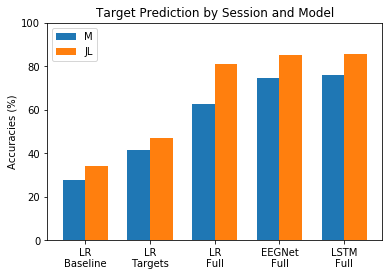

In [70]:
# Grouped bar plots of manually-input data.
monkey_names = ['M', 'JL']
data_types = ['LR\nBaseline', 'LR\nTargets', 'LR\nFull', 'EEGNet\nFull', 'LSTM\nFull']
accuracies = [[27.8, 41.6, 62.7, 74.4, 76.1],[34, 47, 81, 85.4, 85.5]]

ind = np.arange(len(data_types))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
for m_ix, m_name in enumerate(monkey_names):
    ax.bar(ind - width/2 + m_ix * width, accuracies[m_ix], width, label=m_name)

ax.set_ylabel('Accuracies (%)')
ax.set_ylim([0, 100])
ax.set_title('Target Prediction by Session and Model')
ax.set_xticks(ind)
ax.set_xticklabels(data_types)
ax.legend()

fig.savefig(str(datadir / 'converted' / ('Acc_Bars.png')))